# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [ ]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)#/32
        #self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([8, 224, 224, 3])
torch.Size([8])
tensor(1)


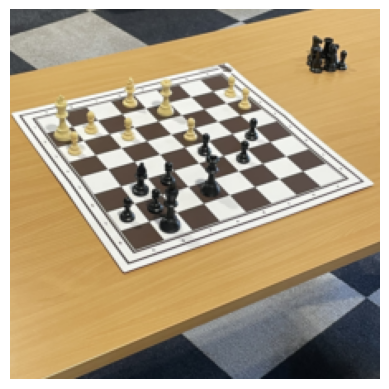

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).unsqueeze(1) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 31 + 1)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu().detach().numpy())
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [12]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 180/180 [00:10<00:00, 17.61it/s]


Train loss: 24.91333 	 Train acc: 3.94959


100%|██████████| 42/42 [00:00<00:00, 56.95it/s]


Val loss: 8.38330 	 Val acc: 2.25277

Epoch 2


100%|██████████| 180/180 [00:09<00:00, 19.55it/s]


Train loss: 7.39020 	 Train acc: 2.11316


100%|██████████| 42/42 [00:00<00:00, 50.56it/s]


Val loss: 6.35813 	 Val acc: 2.03639

Epoch 3


100%|██████████| 180/180 [00:09<00:00, 19.59it/s]


Train loss: 5.51174 	 Train acc: 1.83299


100%|██████████| 42/42 [00:00<00:00, 61.43it/s]


Val loss: 5.10244 	 Val acc: 1.81835

Epoch 4


100%|██████████| 180/180 [00:09<00:00, 18.99it/s]


Train loss: 4.56145 	 Train acc: 1.66959


100%|██████████| 42/42 [00:00<00:00, 61.62it/s]


Val loss: 4.15212 	 Val acc: 1.62189

Epoch 5


100%|██████████| 180/180 [00:09<00:00, 19.63it/s]


Train loss: 3.30756 	 Train acc: 1.43241


100%|██████████| 42/42 [00:00<00:00, 61.97it/s]


Val loss: 4.62183 	 Val acc: 1.70509

Epoch 6


100%|██████████| 180/180 [00:09<00:00, 19.15it/s]


Train loss: 2.55103 	 Train acc: 1.24804


100%|██████████| 42/42 [00:00<00:00, 61.24it/s]


Val loss: 4.10035 	 Val acc: 1.63934

Epoch 7


100%|██████████| 180/180 [00:09<00:00, 19.57it/s]


Train loss: 1.99745 	 Train acc: 1.11291


100%|██████████| 42/42 [00:00<00:00, 61.54it/s]


Val loss: 3.52317 	 Val acc: 1.51682

Epoch 8


100%|██████████| 180/180 [00:09<00:00, 19.21it/s]


Train loss: 1.25637 	 Train acc: 0.89243


100%|██████████| 42/42 [00:00<00:00, 61.18it/s]


Val loss: 3.69538 	 Val acc: 1.56352

Epoch 9


100%|██████████| 180/180 [00:09<00:00, 19.58it/s]


Train loss: 1.13329 	 Train acc: 0.84503


100%|██████████| 42/42 [00:00<00:00, 61.78it/s]


Val loss: 3.32259 	 Val acc: 1.46916

Epoch 10


100%|██████████| 180/180 [00:09<00:00, 19.12it/s]


Train loss: 0.99466 	 Train acc: 0.79449


100%|██████████| 42/42 [00:00<00:00, 59.50it/s]


Val loss: 4.06598 	 Val acc: 1.61203

Epoch 11


100%|██████████| 180/180 [00:09<00:00, 19.56it/s]


Train loss: 0.91636 	 Train acc: 0.75100


100%|██████████| 42/42 [00:00<00:00, 60.62it/s]


Val loss: 3.92173 	 Val acc: 1.57204

Epoch 12


100%|██████████| 180/180 [00:09<00:00, 19.16it/s]


Train loss: 0.74316 	 Train acc: 0.67511


100%|██████████| 42/42 [00:00<00:00, 61.41it/s]


Val loss: 3.45215 	 Val acc: 1.50988

Epoch 13


100%|██████████| 180/180 [00:09<00:00, 19.58it/s]


Train loss: 0.77159 	 Train acc: 0.69603


100%|██████████| 42/42 [00:00<00:00, 61.40it/s]


Val loss: 3.70646 	 Val acc: 1.55112

Epoch 14


100%|██████████| 180/180 [00:09<00:00, 19.10it/s]


Train loss: 0.68073 	 Train acc: 0.64534


100%|██████████| 42/42 [00:00<00:00, 61.61it/s]


Val loss: 3.47092 	 Val acc: 1.50418

Epoch 15


100%|██████████| 180/180 [00:09<00:00, 19.56it/s]


Train loss: 0.64078 	 Train acc: 0.62318


100%|██████████| 42/42 [00:00<00:00, 61.38it/s]


Val loss: 3.37999 	 Val acc: 1.46409

Epoch 16


100%|██████████| 180/180 [00:09<00:00, 19.10it/s]


Train loss: 0.53082 	 Train acc: 0.56591


100%|██████████| 42/42 [00:00<00:00, 61.07it/s]


Val loss: 3.31895 	 Val acc: 1.46109

Epoch 17


100%|██████████| 180/180 [00:09<00:00, 19.34it/s]


Train loss: 0.54309 	 Train acc: 0.57856


100%|██████████| 42/42 [00:00<00:00, 61.46it/s]


Val loss: 4.82793 	 Val acc: 1.75352

Epoch 18


100%|██████████| 180/180 [00:09<00:00, 19.15it/s]


Train loss: 0.51914 	 Train acc: 0.57453


100%|██████████| 42/42 [00:00<00:00, 61.00it/s]


Val loss: 4.41441 	 Val acc: 1.71131

Epoch 19


100%|██████████| 180/180 [00:10<00:00, 17.13it/s]


Train loss: 0.54100 	 Train acc: 0.57031


100%|██████████| 42/42 [00:00<00:00, 48.66it/s]


Val loss: 3.25480 	 Val acc: 1.43063

Epoch 20


100%|██████████| 180/180 [00:11<00:00, 15.53it/s]


Train loss: 0.54475 	 Train acc: 0.57420


100%|██████████| 42/42 [00:00<00:00, 52.63it/s]


Val loss: 4.39010 	 Val acc: 1.66374

Epoch 21


100%|██████████| 180/180 [00:11<00:00, 15.71it/s]


Train loss: 0.50386 	 Train acc: 0.55093


100%|██████████| 42/42 [00:00<00:00, 48.76it/s]


Val loss: 3.04199 	 Val acc: 1.36554

Epoch 22


100%|██████████| 180/180 [00:11<00:00, 16.04it/s]


Train loss: 0.47751 	 Train acc: 0.53181


100%|██████████| 42/42 [00:00<00:00, 50.48it/s]


Val loss: 3.26015 	 Val acc: 1.44192

Epoch 23


100%|██████████| 180/180 [00:11<00:00, 15.80it/s]


Train loss: 0.46908 	 Train acc: 0.53711


100%|██████████| 42/42 [00:00<00:00, 50.17it/s]


Val loss: 3.31965 	 Val acc: 1.44471

Epoch 24


100%|██████████| 180/180 [00:11<00:00, 16.00it/s]


Train loss: 0.46160 	 Train acc: 0.52376


100%|██████████| 42/42 [00:00<00:00, 45.88it/s]


Val loss: 3.79625 	 Val acc: 1.58122

Epoch 25


100%|██████████| 180/180 [00:11<00:00, 15.68it/s]


Train loss: 0.44874 	 Train acc: 0.52041


100%|██████████| 42/42 [00:00<00:00, 49.99it/s]


Val loss: 3.11497 	 Val acc: 1.39437

Epoch 26


100%|██████████| 180/180 [00:11<00:00, 15.81it/s]


Train loss: 0.38713 	 Train acc: 0.48205


100%|██████████| 42/42 [00:00<00:00, 49.80it/s]


Val loss: 3.75459 	 Val acc: 1.55652

Epoch 27


100%|██████████| 180/180 [00:11<00:00, 15.86it/s]


Train loss: 0.39624 	 Train acc: 0.48722


100%|██████████| 42/42 [00:00<00:00, 49.81it/s]


Val loss: 2.99754 	 Val acc: 1.37749

Epoch 28


100%|██████████| 180/180 [00:11<00:00, 15.75it/s]


Train loss: 0.44007 	 Train acc: 0.51374


100%|██████████| 42/42 [00:00<00:00, 54.97it/s]


Val loss: 3.20390 	 Val acc: 1.42341

Epoch 29


100%|██████████| 180/180 [00:11<00:00, 16.16it/s]


Train loss: 0.40521 	 Train acc: 0.48588


100%|██████████| 42/42 [00:00<00:00, 53.26it/s]


Val loss: 4.44852 	 Val acc: 1.69429

Epoch 30


100%|██████████| 180/180 [00:11<00:00, 16.36it/s]


Train loss: 0.40195 	 Train acc: 0.49062


100%|██████████| 42/42 [00:00<00:00, 51.14it/s]


Val loss: 3.23756 	 Val acc: 1.43916

Epoch 31


100%|██████████| 180/180 [00:10<00:00, 16.41it/s]


Train loss: 0.43808 	 Train acc: 0.51056


100%|██████████| 42/42 [00:00<00:00, 51.16it/s]


Val loss: 2.66328 	 Val acc: 1.28078

Epoch 32


100%|██████████| 180/180 [00:11<00:00, 16.34it/s]


Train loss: 0.37070 	 Train acc: 0.46474


100%|██████████| 42/42 [00:00<00:00, 48.95it/s]


Val loss: 2.60389 	 Val acc: 1.29184

Epoch 33


100%|██████████| 180/180 [00:11<00:00, 15.42it/s]


Train loss: 0.40859 	 Train acc: 0.48307


100%|██████████| 42/42 [00:00<00:00, 51.67it/s]


Val loss: 4.11451 	 Val acc: 1.63284

Epoch 34


100%|██████████| 180/180 [00:11<00:00, 15.66it/s]


Train loss: 0.39819 	 Train acc: 0.49187


100%|██████████| 42/42 [00:00<00:00, 49.35it/s]


Val loss: 3.56118 	 Val acc: 1.48224

Epoch 35


100%|██████████| 180/180 [00:11<00:00, 15.91it/s]


Train loss: 0.42338 	 Train acc: 0.49613


100%|██████████| 42/42 [00:00<00:00, 51.13it/s]


Val loss: 3.56378 	 Val acc: 1.48906

Epoch 36


100%|██████████| 180/180 [00:11<00:00, 16.00it/s]


Train loss: 0.37258 	 Train acc: 0.46190


100%|██████████| 42/42 [00:00<00:00, 52.97it/s]


Val loss: 3.08350 	 Val acc: 1.38939

Epoch 37


100%|██████████| 180/180 [00:11<00:00, 15.96it/s]


Train loss: 0.37154 	 Train acc: 0.46050


100%|██████████| 42/42 [00:00<00:00, 52.95it/s]


Val loss: 3.55234 	 Val acc: 1.50801

Epoch 38


100%|██████████| 180/180 [00:11<00:00, 16.09it/s]


Train loss: 0.39951 	 Train acc: 0.48215


100%|██████████| 42/42 [00:00<00:00, 50.95it/s]


Val loss: 2.75379 	 Val acc: 1.33325

Epoch 39


100%|██████████| 180/180 [00:11<00:00, 15.58it/s]


Train loss: 0.35067 	 Train acc: 0.45450


100%|██████████| 42/42 [00:00<00:00, 49.98it/s]


Val loss: 3.12789 	 Val acc: 1.40581

Epoch 40


100%|██████████| 180/180 [00:11<00:00, 15.82it/s]


Train loss: 0.32301 	 Train acc: 0.44014


100%|██████████| 42/42 [00:00<00:00, 46.83it/s]


Val loss: 3.23487 	 Val acc: 1.42035

Epoch 41


100%|██████████| 180/180 [00:11<00:00, 15.69it/s]


Train loss: 0.29768 	 Train acc: 0.41761


100%|██████████| 42/42 [00:00<00:00, 52.37it/s]


Val loss: 2.76367 	 Val acc: 1.29676

Epoch 42


100%|██████████| 180/180 [00:11<00:00, 16.04it/s]


Train loss: 0.27441 	 Train acc: 0.39840


100%|██████████| 42/42 [00:00<00:00, 50.45it/s]


Val loss: 3.58987 	 Val acc: 1.49093

Epoch 43


100%|██████████| 180/180 [00:11<00:00, 16.10it/s]


Train loss: 0.27361 	 Train acc: 0.39844


100%|██████████| 42/42 [00:00<00:00, 50.23it/s]


Val loss: 2.99855 	 Val acc: 1.39959

Epoch 44


100%|██████████| 180/180 [00:11<00:00, 15.65it/s]


Train loss: 0.28156 	 Train acc: 0.40546


100%|██████████| 42/42 [00:00<00:00, 51.42it/s]


Val loss: 3.05097 	 Val acc: 1.38862

Epoch 45


100%|██████████| 180/180 [00:11<00:00, 15.82it/s]


Train loss: 0.28712 	 Train acc: 0.40121


100%|██████████| 42/42 [00:00<00:00, 53.03it/s]


Val loss: 2.79617 	 Val acc: 1.34437

Epoch 46


100%|██████████| 180/180 [00:11<00:00, 15.72it/s]


Train loss: 0.24865 	 Train acc: 0.37926


100%|██████████| 42/42 [00:00<00:00, 48.43it/s]


Val loss: 3.48164 	 Val acc: 1.47088

Epoch 47


100%|██████████| 180/180 [00:11<00:00, 15.48it/s]


Train loss: 0.25640 	 Train acc: 0.38650


100%|██████████| 42/42 [00:00<00:00, 53.49it/s]


Val loss: 3.57805 	 Val acc: 1.49333

Epoch 48


100%|██████████| 180/180 [00:11<00:00, 16.08it/s]


Train loss: 0.24282 	 Train acc: 0.36760


100%|██████████| 42/42 [00:00<00:00, 48.28it/s]


Val loss: 2.82253 	 Val acc: 1.33704

Epoch 49


100%|██████████| 180/180 [00:11<00:00, 15.79it/s]


Train loss: 0.26258 	 Train acc: 0.39305


100%|██████████| 42/42 [00:00<00:00, 51.23it/s]


Val loss: 2.66028 	 Val acc: 1.30236

Epoch 50


100%|██████████| 180/180 [00:11<00:00, 15.29it/s]


Train loss: 0.30031 	 Train acc: 0.42150


100%|██████████| 42/42 [00:00<00:00, 51.75it/s]


Val loss: 3.15505 	 Val acc: 1.38159
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [16]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

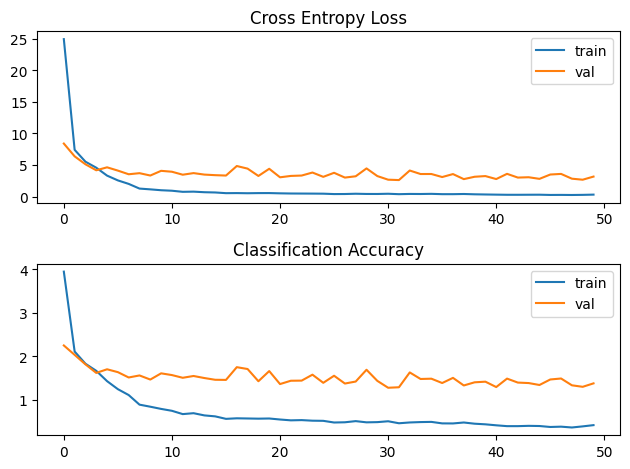

In [17]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [18]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*32
        preds.extend(predsTmp)
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        #print(original_values)
    return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 39/39 [00:00<00:00, 39.14it/s]

Test loss: 1.181


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?